<a href="https://colab.research.google.com/github/abhinavgairola/Anomaly_Detection_OTC_Market/blob/main/Read_parquet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install mplfinance

In [6]:
!pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)


In [7]:
!pip install emoji --upgrade

Requirement already up-to-date: emoji in /usr/local/lib/python3.7/dist-packages (1.2.0)


In [8]:
import pandas_datareader as pdr
import pandas as pd
import datetime
import matplotlib.pyplot as mp
import string
import numpy as np
import re
import json
from google.colab import drive
drive.mount('/content/drive')
import pyarrow as pa
import json
from sklearn import preprocessing
import calendar
import seaborn as sns
import plotly.express as px
import mplfinance as mpf
import matplotlib.font_manager
mp.style.use('dark_background')
mp.rcParams["font.family"] = "Times New Roman"
cm = sns.light_palette("green", as_cmap=True)
import random
from collections import Counter
from palettable.colorbrewer.sequential import YlOrRd_9, Greys_9

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#dir(mpf)

In [10]:
help(mpf.make_addplot)

Help on function make_addplot in module mplfinance.plotting:

make_addplot(data, **kwargs)
    Take data (pd.Series, pd.DataFrame, np.ndarray of floats, list of floats), and
    kwargs (see valid_addplot_kwargs_table) and construct a correctly structured dict
    to be passed into plot() using kwarg `addplot`.  
    NOTE WELL: len(data) here must match the len(data) passed into plot()



In [11]:
help(mpf.make_marketcolors)

Help on function make_marketcolors in module mplfinance._styles:

make_marketcolors(**kwargs)
    Create a 'marketcolors' dict that is structured as expected
    by mplfinance._styles code:
        up     = color for close >= open
        down   = color for close  < open
        edge   = color for edge of candlestick; if "inherit"
                 then edge color will be same as up or down.
        wick   = color for wick of candlestick; if "inherit"
                 then wick color will be same as up or down.
        alpha  = opacity, 0.0 to 1.0, of candlestick face.
        ohlc   = color of ohlc bars when all the same color;
                 if ohlc == "inherit" then use up/down colors.
        volume = color of volume bars when all the same color;
                 if volume == "inherit" then use up/down colors.



##Read the stocks data from the Parquet file

In [12]:
df_stocks = pd.read_parquet('/content/drive/MyDrive/OTCMKT/Stocks_data_3.parquet.gzip')


In [13]:
### Compute daily average using open, close, high, low and adjusted close price.
df_daily_average=(df_stocks['Open']+df_stocks['Close']+df_stocks['High']+df_stocks['Low'])/4

In [14]:
### Filter the columns where tghe NaN is less than 50%
df_daily_average = df_daily_average[df_daily_average.columns[df_daily_average.isnull().mean()<=0.5]].fillna(0)

In [15]:
df_daily_average.index.date

array([datetime.date(2016, 1, 4), datetime.date(2016, 1, 5),
       datetime.date(2016, 1, 6), ..., datetime.date(2021, 4, 9),
       datetime.date(2021, 4, 12), datetime.date(2021, 4, 13)],
      dtype=object)

## Read the tweet data from the json file and bring it to shape

In [16]:
#with open('/content/drive/MyDrive/OTCMKT/All_tweets_with_emojis_with_punctuations.json','r') as f:
#  data = (json.load(f))

   

In [17]:
#test = pd.DataFrame.from_dict(data, orient='index')

In [18]:

#test

In [19]:
#test = test.T

In [20]:
#columns = test.columns.str.startswith('Date')
#columns_2 = test.columns.str.startswith('Tweets')
#columns = test.columns[columns]
#test.melt(id_vars=list(columns),value_vars=list(test.columns[columns_2]))

In [21]:
#df = pd.DataFrame.from_dict(data, orient='index')
#print(df)
## This I am doing it to bring it to proper shape.
#Dates = []
#Tweets = []
#Ticker  = []
#for key, vals in data.items():
#  if key.find('Date')>-1:
#    Dates = Dates+vals
#  elif key.find('Tweets')>-1:
#    Tweets = Tweets+vals
#    Ticker = Ticker + [key.split('Tweets')[1]]*len(vals)
#df_tweets = pd.DataFrame({'Dates':Dates,'Tweets':Tweets,'Ticker':Ticker})

In [22]:
## Convert dates column to datetime index
#df_tweets['Dates'] = pd.to_datetime(df_tweets['Dates'])
#df_tweets.set_index('Dates')[['Ticker','Tweets']].to_parquet('/content/drive/MyDrive/OTCMKT/All_tweets_correct_format.parquet.gzip',
#              compression='gzip')
df_tweets = pd.read_parquet('/content/drive/MyDrive/OTCMKT/All_tweets_correct_format.parquet.gzip')

### Read the tickers which are only in the OTCMKT for a word cloud plot.
with open('/content/drive/MyDrive/OTCMKT/Tickers.txt','r') as f:
  lines= (f.readlines())
All_tickers = [x.replace('\n','') for x in lines]

In [23]:
df_tweets = df_tweets.reset_index()#.set_index('Dates')[['Ticker','Tweets']]
df_tweets.rename(columns={'Dates':'Date'},inplace=True)

In [24]:
Available_ticks = list(df_daily_average.columns)
#Available_ticks

In [25]:
df_tweets=df_tweets[df_tweets.Ticker.isin(Available_ticks)]

In [26]:
bar_plot_data = pd.DataFrame(df_tweets.set_index('Date').groupby('Ticker')['Tweets'].count()).reset_index().sort_values(by='Tweets',ascending=True).rename(columns={'Tweets':'Counts'})

In [27]:
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(YlOrRd_9.colors[random.randint(2,8)])

def color_func_2(word, font_size, position, orientation, random_state=None, **kwargs):
    return tuple(Greys_9.colors[random.randint(2,8)])

In [28]:
import emoji
import re
import string
from gensim.parsing.preprocessing import remove_stopwords
from IPython.display import Image
pattern = re.compile(emoji.get_emoji_regexp())
without_emoji = df_tweets.iloc[0:8000,:].copy()
without_emoji.Tweets = without_emoji.Tweets.apply(lambda x : remove_stopwords(re.sub(pattern,'',x)))
without_emoji.Tweets = without_emoji.Tweets.apply(lambda x: x.strip(string.punctuation).upper().split())
without_emoji= without_emoji.rename(columns={'Tweets':'Tweets_tokenize'})

words = ','.join([items.replace(string.punctuation,'') for lists in without_emoji.Tweets_tokenize for items in lists])
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image as im



In [29]:
test = [items for lists in without_emoji.Tweets_tokenize for items in lists]
All_tickers_2 = []
for items in test:
  if len(items) == 4 and items in All_tickers:
    All_tickers_2.append(items)
  elif len(items)!=4:
    All_tickers_2.append(items)
words_2 = ','.join(All_tickers_2)


In [32]:
#icon = im.open('/content/drive/MyDrive/OTCMKT/OTC3.png')
#mask = im.new("RGB", icon.size, (255,255,255))
#mask.paste(icon,icon)
#mask = np.array(mask)
mask = np.array(im.open('/content/drive/MyDrive/OTCMKT/OTC.jpeg'))
#image_colors = ImageColorGenerator(np.array(mask))
#wordcloud = WordCloud(mask=mask, background_color="white",
#               max_words=2000, max_font_size=300,
#               random_state=42,font_path='/content/drive/MyDrive/OTCMKT/Din_Condensed.ttf').generate(words)#width=mask.shape[1],height=mask.shape[0]
#mp.imshow(wordcloud, interpolation='bilinear')
#mp.axis("off")
#mp.show()
#wordcloud.recolor(color_func=color_func, random_state=3)
#wordcloud.to_file("/content/drive/MyDrive/OTCMKT/Word_Cloud.png")
#Image(filename='/content/drive/MyDrive/OTCMKT/Word_Cloud.png') 

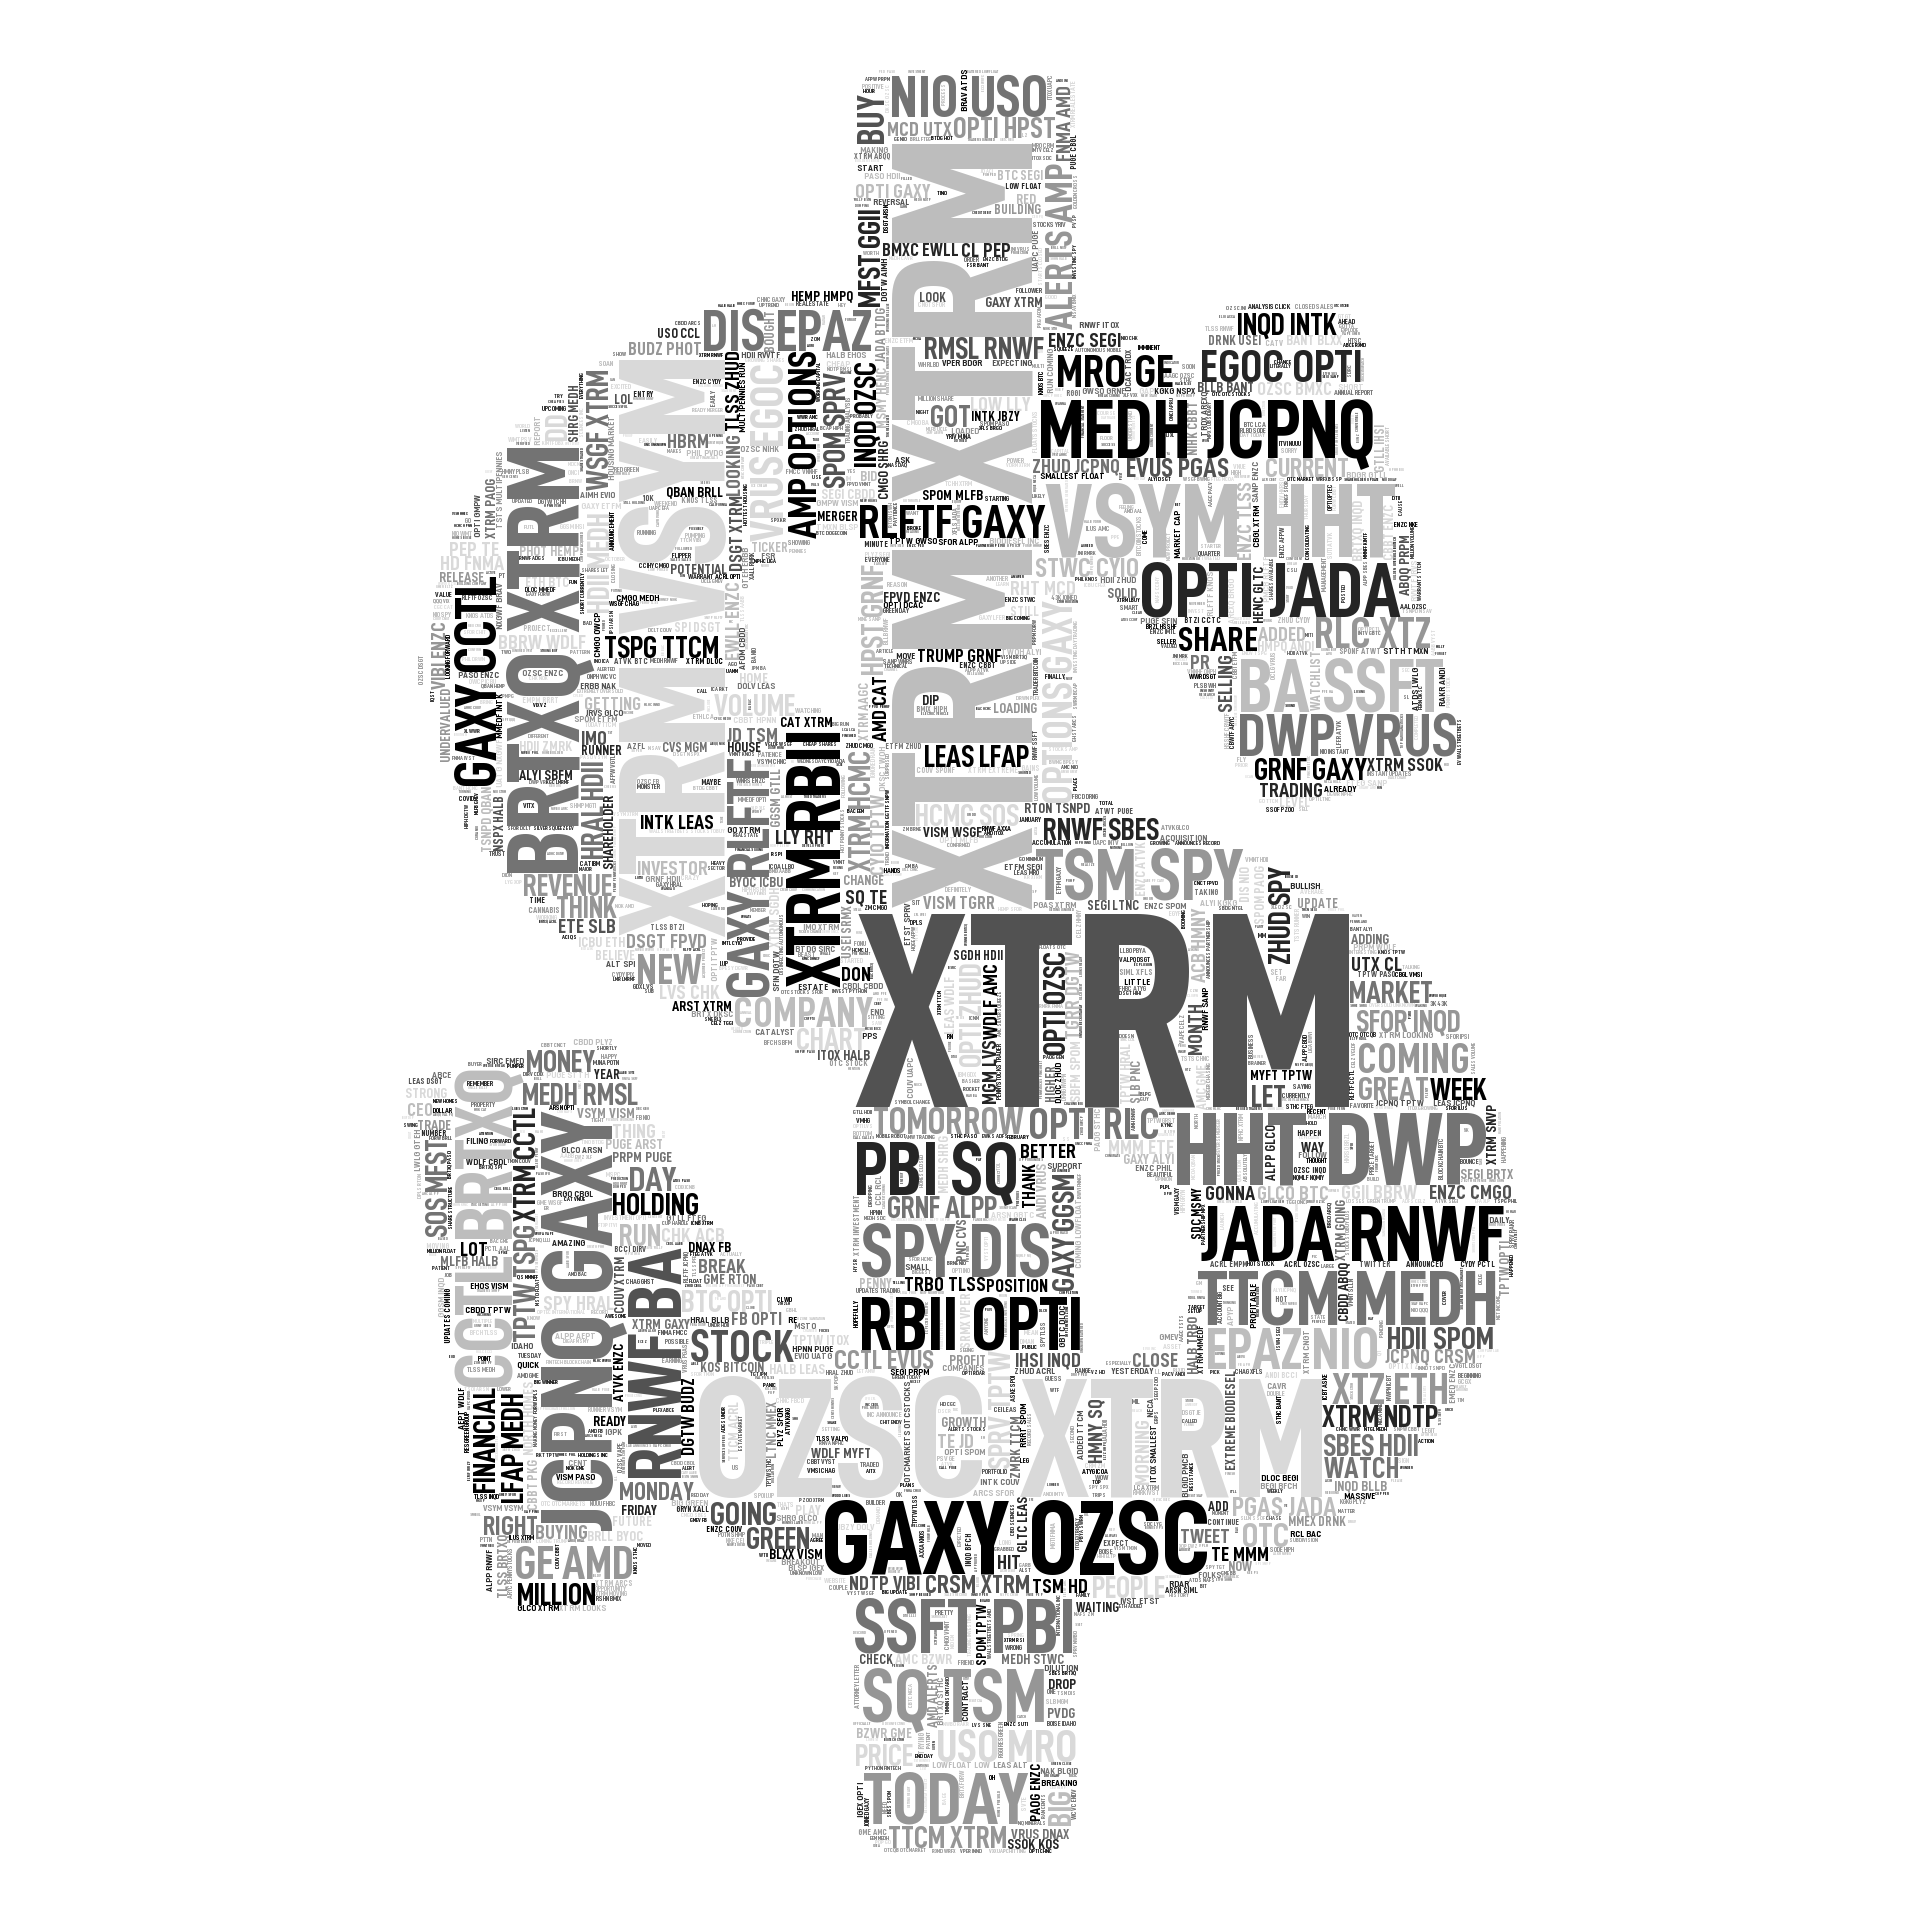

In [35]:
wordcloud = WordCloud(mask=mask, background_color="white",
               max_words=2000, max_font_size=300,
               random_state=42,font_path='/content/drive/MyDrive/OTCMKT/Din_Condensed.ttf').generate(words_2)#width=mask.shape[1],height=mask.shape[0]
#mp.imshow(wordcloud, interpolation='bilinear')
#mp.axis("off")
#mp.show()
wordcloud.recolor(color_func=color_func_2, random_state=3)
wordcloud.to_file("/content/drive/MyDrive/OTCMKT/Word_Cloud_2.png")
Image(filename='/content/drive/MyDrive/OTCMKT/Word_Cloud_2.png') 

In [36]:
TICKER_to_plot = 'OPTI'
Candle_stick=pd.DataFrame(index=df_stocks[('Adj Close')][TICKER_to_plot].index,data={'Open':df_stocks[('Open')][TICKER_to_plot].values,'Close':df_stocks[('Close')][TICKER_to_plot].values,'High':df_stocks[('High')][TICKER_to_plot].values,'Low':df_stocks[('Low')][TICKER_to_plot].values,'Volume':df_stocks[('Volume')][TICKER_to_plot].values})

In [37]:
period = 20 
multiplier = 2
Candle_stick['UpperBand'] = Candle_stick['Close'].rolling(period).mean() + Candle_stick['Close'].rolling(period).std() * multiplier
Candle_stick['LowerBand'] = Candle_stick['Close'].rolling(period).mean() - Candle_stick['Close'].rolling(period).std() * multiplier

In [38]:
Candle_stick

,Open,Close,High,Low,Volume,UpperBand,LowerBand
Date,,,,,,,
2016-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-04-07,0.1550,0.1360,0.1600,0.13520,11971581.0,0.177288,0.100991
2021-04-08,0.1350,0.1310,0.1450,0.12197,16413581.0,0.176596,0.100223
2021-04-09,0.1315,0.1290,0.1340,0.11850,11508660.0,0.173843,0.099870


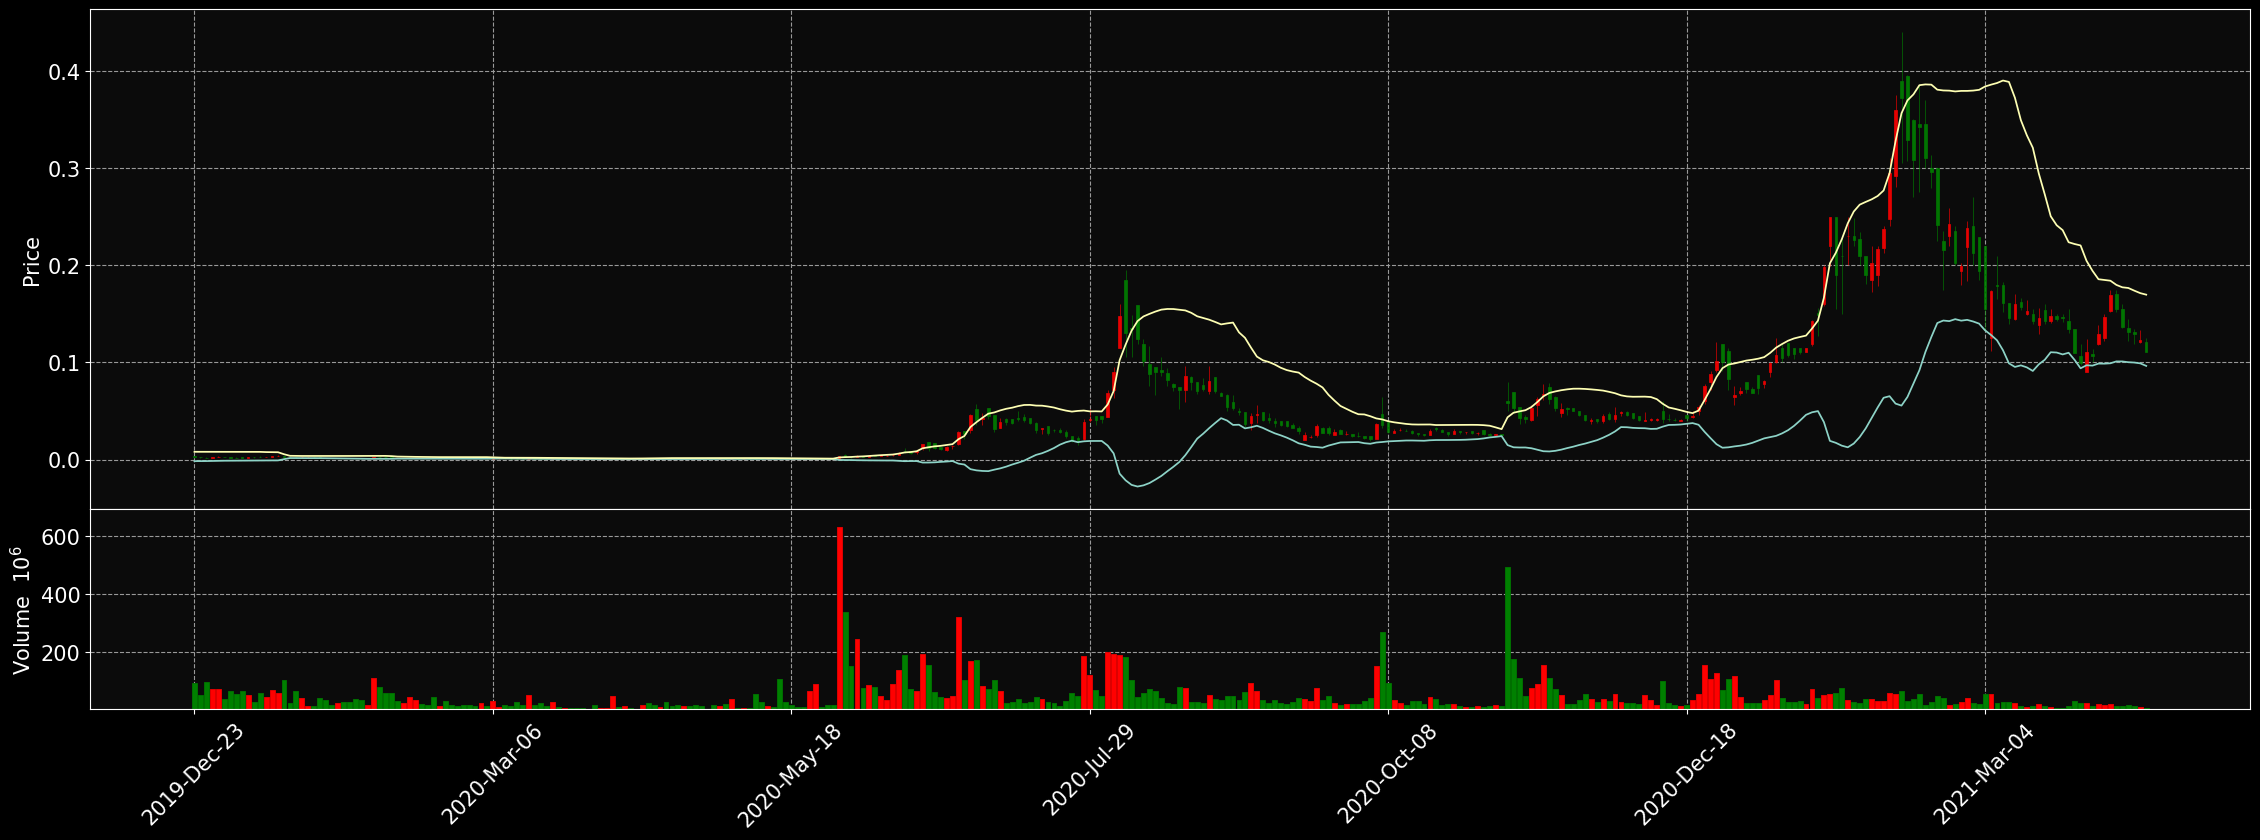

In [39]:
tcdf = Candle_stick[['LowerBand','UpperBand']]  
apd  = mpf.make_addplot(tcdf.iloc[1000:1400,:])
mc = mpf.make_marketcolors(up='#FF0000',down='#008000',inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='nightclouds',marketcolors=mc)
mpf.plot(Candle_stick.iloc[1000:1400,:], type='candle',figsize=(30,10),addplot=apd,volume=True,fontscale=1.5,style=s)


##[Candle stick]((https://en.wikipedia.org/wiki/Candlestick_chart)) chart showing the [Bollinger bands](https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/bollinger-bands#:~:text=Bollinger%20Bands%20are%20envelopes%20plotted,Period%20and%20Standard%20Deviations%2C%20StdDev.) together with the Open, Close, High and Low at each day and the volume of the traded stock (ticker name:UBQU). More can be learned from [here](https://finance.yahoo.com/news/read-candle-chart-190000711.html). Some interesting patterns like [bullish engulfing](https://www.dailyfx.com/education/candlestick-patterns/bullish-engulfing.html) can be checked from here too.

In [40]:
bar_plot_2 = pd.DataFrame(df_tweets.groupby(['Date','Ticker'])['Tweets'].count())
#bar_plot_2[bar_plot_2.Ticker=='ABQQ']
pd.DataFrame(df_tweets.set_index('Date').groupby('Ticker')['Tweets'].count()).reset_index().sort_values(by='Tweets',ascending=True).rename(columns={'Tweets':'Counts'})

,Ticker,Counts
886,WWNG,8
734,SNYL,10
883,WTRO,11
336,GPKE,13
84,BFLD,16
...,...,...
306,GBTC,95739
509,MINE,97953
195,DIRV,102652
249,ENZC,112244


In [41]:
#df_tweets[df_tweets.Ticker =='UBQU']
bar_plot_2 = bar_plot_2.reset_index()
UBQU = bar_plot_2[bar_plot_2.sort_values(by='Ticker',ascending=False).Ticker == 'UBQU']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
UBQU['Date'].filter(items=list(UBQU.Date.values[0:10]))

Series([], Name: Date, dtype: datetime64[ns])

In [43]:
UBQU=UBQU.rename(columns={'Tweets':'Counts'})

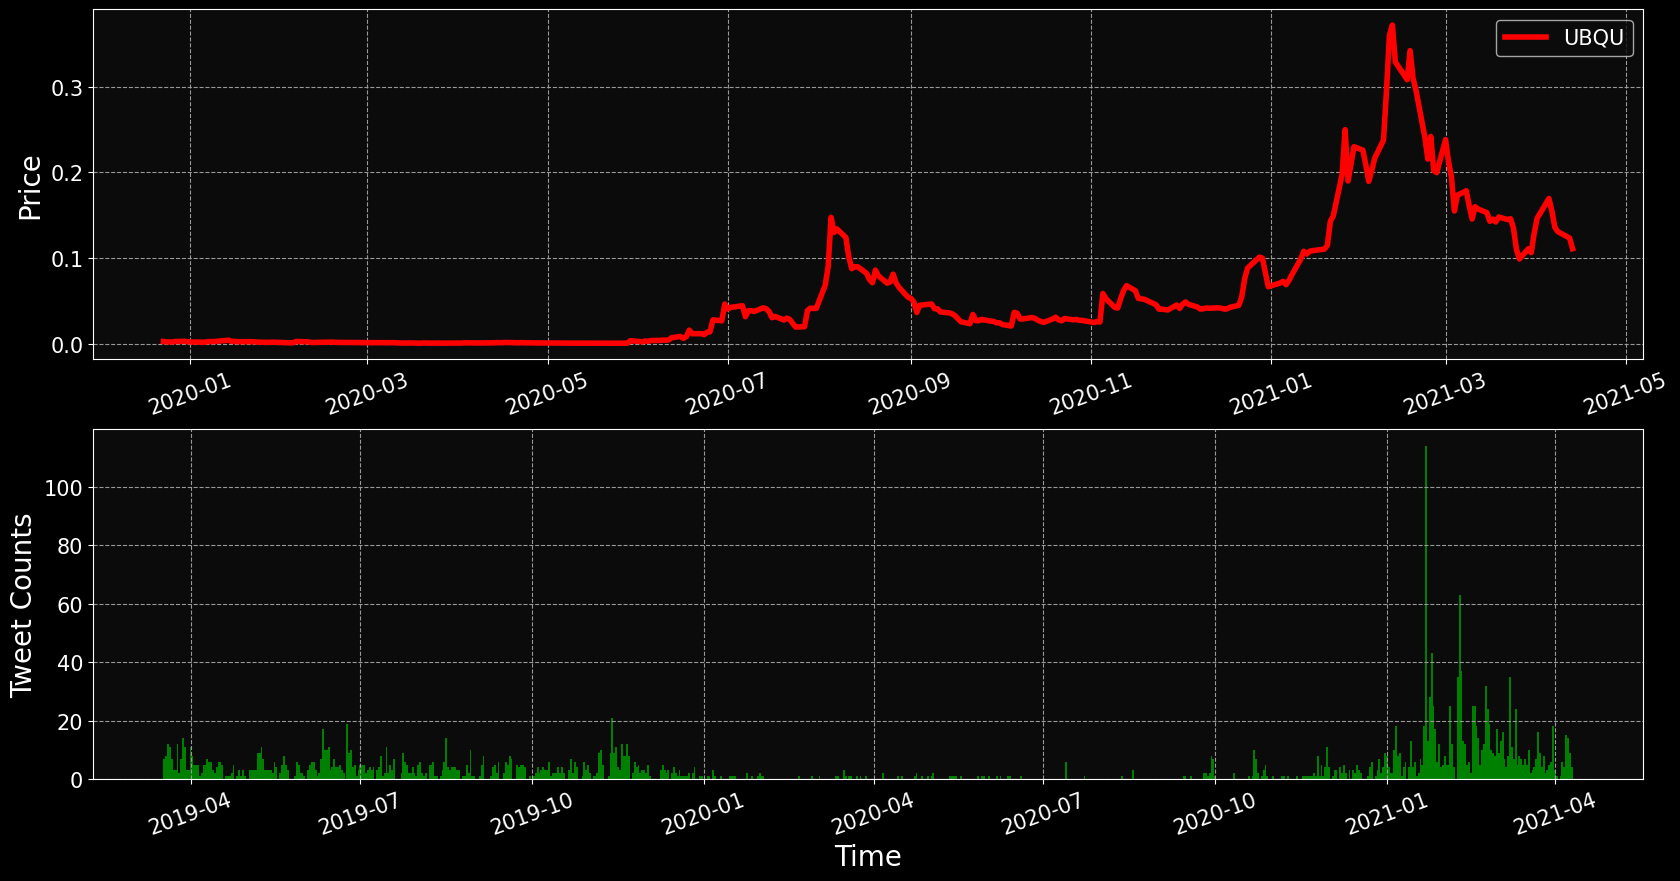

In [44]:

x =UBQU['Date']
y= UBQU['Counts']
fig, ax = mp.subplots(2,1,figsize=(20,10))
ax[0].plot(Candle_stick.index[1000:2400], Candle_stick['Close'][1000:2400],color='red',linewidth=4,label='UBQU')
mp.setp(ax[1].get_xticklabels(), rotation=20)
mp.setp(ax[0].get_xticklabels(), rotation=20)
ax[1].bar(x[1000:2400],y[1000:2400],color='green',width=1.0)
ax[1].set_xlabel('Time',fontsize=20)
ax[1].set_ylabel('Tweet Counts',fontsize=20)
ax[0].set_ylabel('Price',fontsize=20)
ax[0].legend(loc='best')

In [45]:
help(mpf.plot)

Help on function plot in module mplfinance.plotting:

plot(data, **kwargs)
    Given a Pandas DataFrame containing columns Open,High,Low,Close and optionally Volume
    with a DatetimeIndex, plot the data.
    Available plots include ohlc bars, candlestick, and line plots.
    Also provide visually analysis in the form of common technical studies, such as:
    moving averages, renko, etc.
    Also provide ability to plot trading signals, and/or addtional user-defined data.



In [46]:
bar_plot_2 = bar_plot_2.sort_values(by='Tweets').tail(1000)

In [47]:
bar_plot_2

,Date,Ticker,Tweets
88428,2017-04-03,MMEX,546
21791,2016-04-17,HVCW,546
68153,2016-12-27,UBQU,546
538188,2021-02-03,FTEG,547
446138,2020-07-13,OPTI,547
...,...,...,...
537533,2021-02-02,HCMC,3691
20672,2016-04-12,ECEZ,3746
541583,2021-02-08,HCMC,4684
551938,2021-02-23,ANDI,5301


In [48]:
#fig = px.treemap(bar_plot_2, path=['Ticker', 'Date'], values='Tweets',color='Ticker',color_continuous_scale=px.colors.sequential.RdBu)
#fig.update_layout(font=dict(family="Times New Roman",
#        size=18,
#        color="white"),plot_bgcolor='rgba(0,0,0,1)',paper_bgcolor= 'rgba(0, 0, 0, 1)')
#fig.show()




[//]: # (The above plots represents the heirarchical information about the tickers--there tickers inside which the dates are listed while the tweet counts represent the size of each date box. Clearly HCMC and ENZC are tweeted many times across multiple dates. It might happen later that these are the most severly pumped OTC market stocks.)

Text(0, 0.5, 'Tickers')

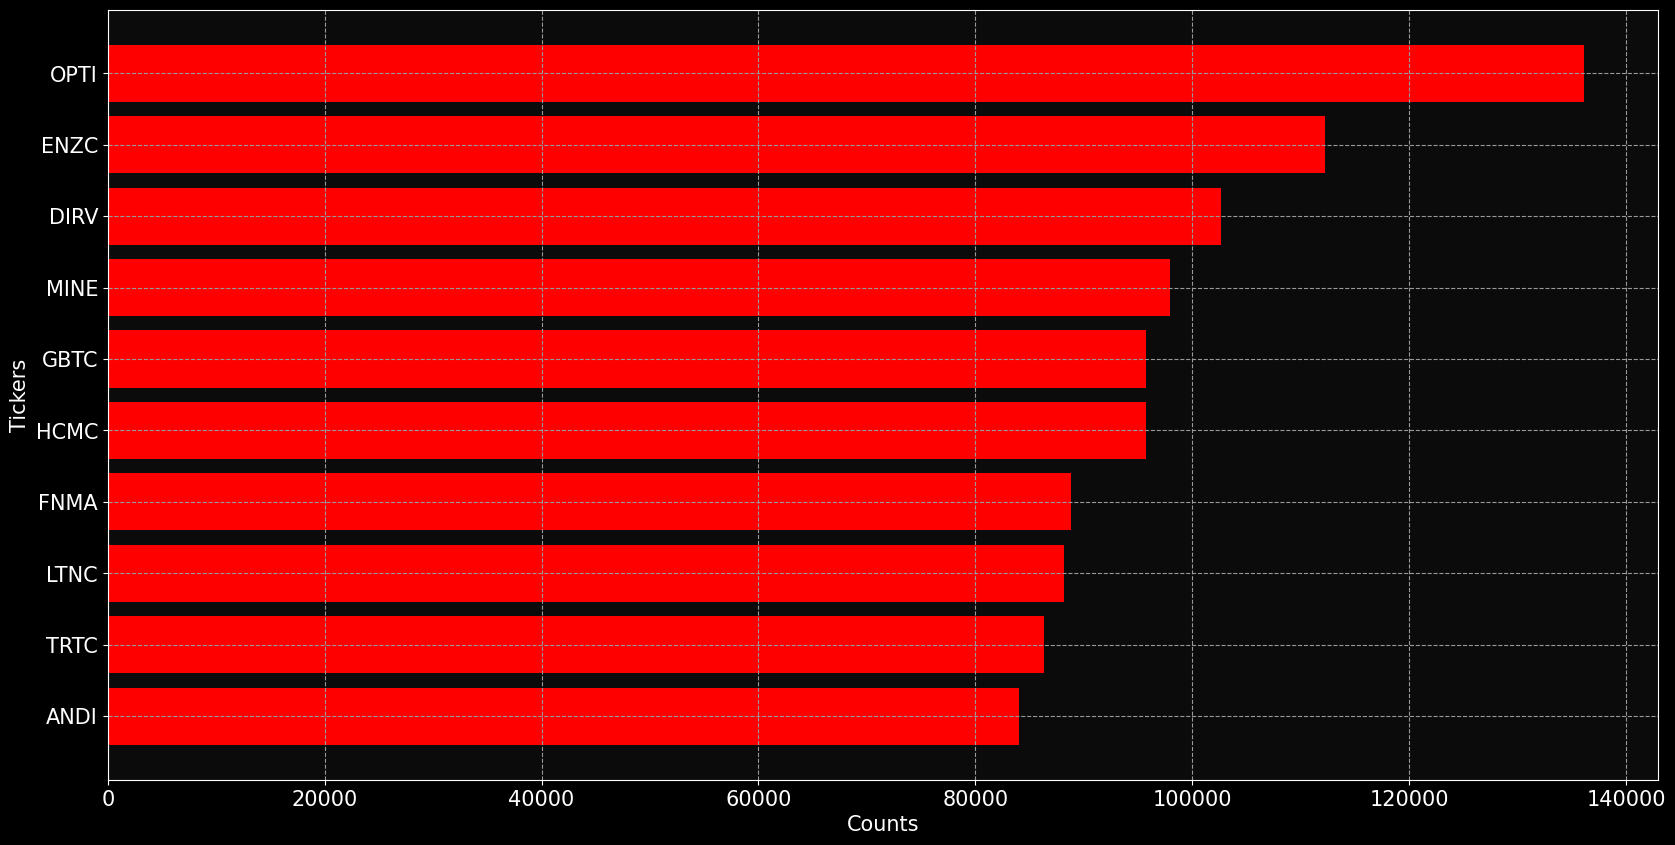

In [49]:
#fig_1 = px.bar(bar_plot_data.tail(50), x='Counts', y='Ticker',orientation='h',labels=dict(x="Counts", y="Keywords"),color='Counts',color_continuous_scale=px.colors.sequential.Reds)
#fig_1.update_layout(font=dict(family="Times New Roman",size=18,color="white"),plot_bgcolor='rgba(0,0,0,1)',paper_bgcolor= 'rgba(0, 0, 0, 1)')
#fig_1.show()
bar_data_ = bar_plot_data.tail(10)
mp.figure(figsize=(20,10))
mp.barh(bar_data_['Ticker'],bar_data_['Counts'],color='red', align='center')
mp.xlabel('Counts')
mp.ylabel('Tickers')
# As plotly doesn't render.

## Tweets and their counts are shown in the above plot

In [50]:
columns_list_of_stocks = list(bar_plot_data.tail(600).Ticker.values)#df_daily_average.columns)


In [51]:
## loc doesn't support list with missing values anymore using filter method.
#df_daily_average['XTRM'].filter(items=time_list_unique).plot(figsize=(20,10))
#columns_list_of_stocks = sorted(columns_list_of_stocks)[::-1]

In [52]:

df_daily_average_copy = df_daily_average.copy()


def mean_std(Ticker_name,dataframe):

  """
  The utility of this method is 
  1) Select those days where the tweet counts is > 100.
  2) Compute the 20 days backward average as mentioned in this work:-https://qspace.library.queensu.ca/bitstream/handle/1974/28239/David_Nam_K_202010_MSC.pdf?sequence=2&isAllowed=y
  3) Compute the standard deviation too on the same time scale
  """

  time_delta = datetime.timedelta(1)

  df_daily_average_copy = dataframe.copy()
  
  ## select those days where the tweet counts is > 100
  time_list = list(df_tweets[df_tweets['Ticker'] == Ticker_name].groupby('Date')['Tweets'].count()[df_tweets[df_tweets['Ticker'] == Ticker_name].groupby('Date')['Tweets'].count().apply(lambda x: x>=100)].index)#list((df_tweets[df_tweets['Ticker'] == Ticker_name]['Dates']))
  
  #print(df_tweets[df_tweets['Ticker'] == Ticker_name].groupby('Date')['Tweets'].count()[df_tweets[df_tweets['Ticker'] == Ticker_name].groupby('Date')['Tweets'].count().apply(lambda x: x>=100)])
  time_list_unique=(time_list)#list(pd.to_datetime((df_tweets[df_tweets['Ticker'] == Ticker_name]['Dates'].unique())))

  #print(time_list_unique)
  date = []
  Data_mean = []
  Data_std = []
  
  for time in time_list_unique[::-1]:

    filtering = [time-i*time_delta for i in range(1,20) if calendar.day_name[(time-i*time_delta).weekday()] in ['Monday','Tuesday','Wednesday','Thursday','Friday'] ]
    date.append(time)
    Data_mean.append(df_daily_average_copy[Ticker_name].filter(items=filtering).dropna().mean())
    Data_std.append(df_daily_average_copy[Ticker_name].filter(items=filtering).dropna().std())

  return pd.DataFrame({'Date':date,'Mean_'+Ticker_name:Data_mean,'Std_'+Ticker_name:Data_std}).set_index('Date')


## Loop through the tickers and merge the above computation to the copy of the stock dataframe.
for idx,tick in enumerate(columns_list_of_stocks[0:600]):
  #print(colored(idx,'red'),colored(tick,'green') )
  intermediate = mean_std(tick,df_daily_average)
  #print(test)

  df_daily_average_copy = pd.concat([df_daily_average_copy,intermediate],axis=1)#df_daily_average_copy.combine_first(test)
  #test_4 = pd.concat([df_daily_average,test_3],axis=1).rename(columns={0:'Indicator_XTRM'})
  #test_4 =pd.concat([test_4,test_5],axis=1).rename(columns={'Tweets':'Tweets_XTRM'})

#df_daily_average=df_daily_average.combine_first(pd.DataFrame({'Date':date,'Ticker_mean':XTRM_mean,'Ticker_std':XTRM_std}).set_index('Date'))
#df_daily_average

In [53]:

Mean_data = df_daily_average_copy[df_daily_average_copy.columns[df_daily_average_copy.columns.str.startswith("Mean")]]


In [54]:
Std_data = df_daily_average_copy[df_daily_average_copy.columns[df_daily_average_copy.columns.str.startswith("Std")]]

In [55]:
Mean_data.isnull().mean()#.style.background_gradient(cmap=cm)

Mean_MBLV    0.998813
Mean_AMNL    1.000000
Mean_PRMO    0.998220
Mean_AFTC    1.000000
Mean_VDRM    0.998220
               ...   
Mean_GBTC    0.842730
Mean_MINE    0.858160
Mean_DIRV    0.852226
Mean_ENZC    0.880712
Mean_OPTI    0.814837
Length: 600, dtype: float64

In [56]:
Std_data.isnull().mean()

Std_MBLV    0.998813
Std_AMNL    1.000000
Std_PRMO    0.998220
Std_AFTC    1.000000
Std_VDRM    0.998220
              ...   
Std_GBTC    0.842730
Std_MINE    0.858160
Std_DIRV    0.852226
Std_ENZC    0.880712
Std_OPTI    0.814837
Length: 600, dtype: float64

In [57]:
df_tweets.rename(columns={'Dates':'Date'},inplace=True)

In [58]:
#(pd.DataFrame({'Date':date,'Ticker_mean':XTRM_mean}).set_index('Date')).plot(marker='o',figsize=(40,10))
#df_daily_average['Ticker_mean'].plot(marker='*',figsize=(40,10),color='green')
#df_daily_average['XTRM'].dropna().plot(figsize=(20,10))
final_df = df_daily_average.copy()
def helper_label(list_,df_):
  """
  1) Create indicator 0 (No pump) and 1 (pump) variables by comparing the average price of the day with the 2*backward looking standard deviation + backward looking mean for the selected days.
  2) Count the tweets for the ticker by grouping them with the date.
  3) Merge the two variables with the data frame.
  """
  for idx,tick in enumerate(list_):
    indicator = pd.DataFrame((df_daily_average_copy[tick] > 2*df_daily_average_copy['Std'+'_'+tick]+df_daily_average_copy['Mean_'+tick]).astype(int))
    #mp.figure(idx,figsize=(20,10))
    tweets = df_tweets[df_tweets['Ticker']==tick].groupby('Date')['Tweets'].count()
    normal_tweet  = ((tweets-tweets.min())/(tweets.max()-tweets.min()))
    #mp.plot(normal_tweet.index,normal_tweet.values,label="Tweet_"+tick)
    normal_data = ((df_daily_average_copy[tick]-df_daily_average_copy[tick].min())/(df_daily_average_copy[tick].max()-df_daily_average_copy[tick].min())).dropna()#.plot()
    #mp.plot(normal_data.index, normal_data.values,label='Stock_'+tick)
    #mp.plot(indicator.index,indicator.values,label='label'+'_'+tick)
    #mp.legend(loc='best')
    #print("This is indicator {}".format(indicator))
    df_ = pd.concat([df_,indicator],axis=1).rename(columns={0:'Indicator_'+tick})
    df_ = pd.concat([df_,tweets],axis=1).rename(columns={'Tweets':'Tweets_'+tick})

  return df_
temporary_step = helper_label(columns_list_of_stocks[0:600],final_df)
#temporary_step

In [59]:

#pd.concat([t[['Tweets_RGBP','Indicator_RGBP','XTRM']].melt(id_vars='Tweets_RGBP',value_vars=['Indicator_RGBP']),pd.DataFrame(t[['Tweets_RGBP','Indicator_RGBP','XTRM']].index)],axis=1)
#t.columns[list(t.columns.str.startswith('Tweet'))

def cleaning_up(columns_list_of_stocks, idx,df_):
  """
  Create a clean melted dataframe with id variables Tweets_tickers and value variables as Indicator
  """

  df_clean = pd.DataFrame()
  #indexes = []

  for tick in columns_list_of_stocks[0:idx]:
    temp = pd.concat([df_[['Tweets_'+tick,'Indicator_'+tick,tick]].melt(id_vars='Tweets_'+tick,value_vars=['Indicator_'+tick]),pd.DataFrame(df_[['Tweets_'+tick,'Indicator_'+tick,tick]].index)],axis=1)
    #temp = pd.concat([temp,pd.DataFrame(df_[tick].values)],axis=1)
    temp.rename(columns={'Tweets_'+tick:'Tweet_counts'},inplace=True)
    df_clean = pd.concat([df_clean,temp],axis=0)
    #df_clean = pd.concat([df_clean,(df_[tick])],axis=1)
    #print(list(df_[tick].index))
    #indexes = indexes+list(df_[tick].index)
  #print(df_clean)
  return df_clean.rename(columns={0:'Price'})#,indexes

all_clean = cleaning_up(columns_list_of_stocks,600,temporary_step)
all_clean.rename(columns={'value':'Indicator'},inplace=True)
## Keep the indicators where only more than 100 tweets are there as it was the case above.
all_clean = all_clean[all_clean['Tweet_counts']>=100]
all_clean['variable'] = all_clean['variable'].apply(lambda x: x.split('_')[1])
all_clean

,Tweet_counts,variable,Indicator,Date
1851,100.0,MBLV,1.0,2021-01-25
1860,132.0,MBLV,1.0,2021-02-03
1865,105.0,PRMO,1.0,2021-02-08
1866,143.0,PRMO,1.0,2021-02-09
1867,137.0,PRMO,1.0,2021-02-10
...,...,...,...,...
1921,375.0,OPTI,0.0,2021-04-05
1922,309.0,OPTI,0.0,2021-04-06
1923,334.0,OPTI,0.0,2021-04-07
1924,510.0,OPTI,0.0,2021-04-08


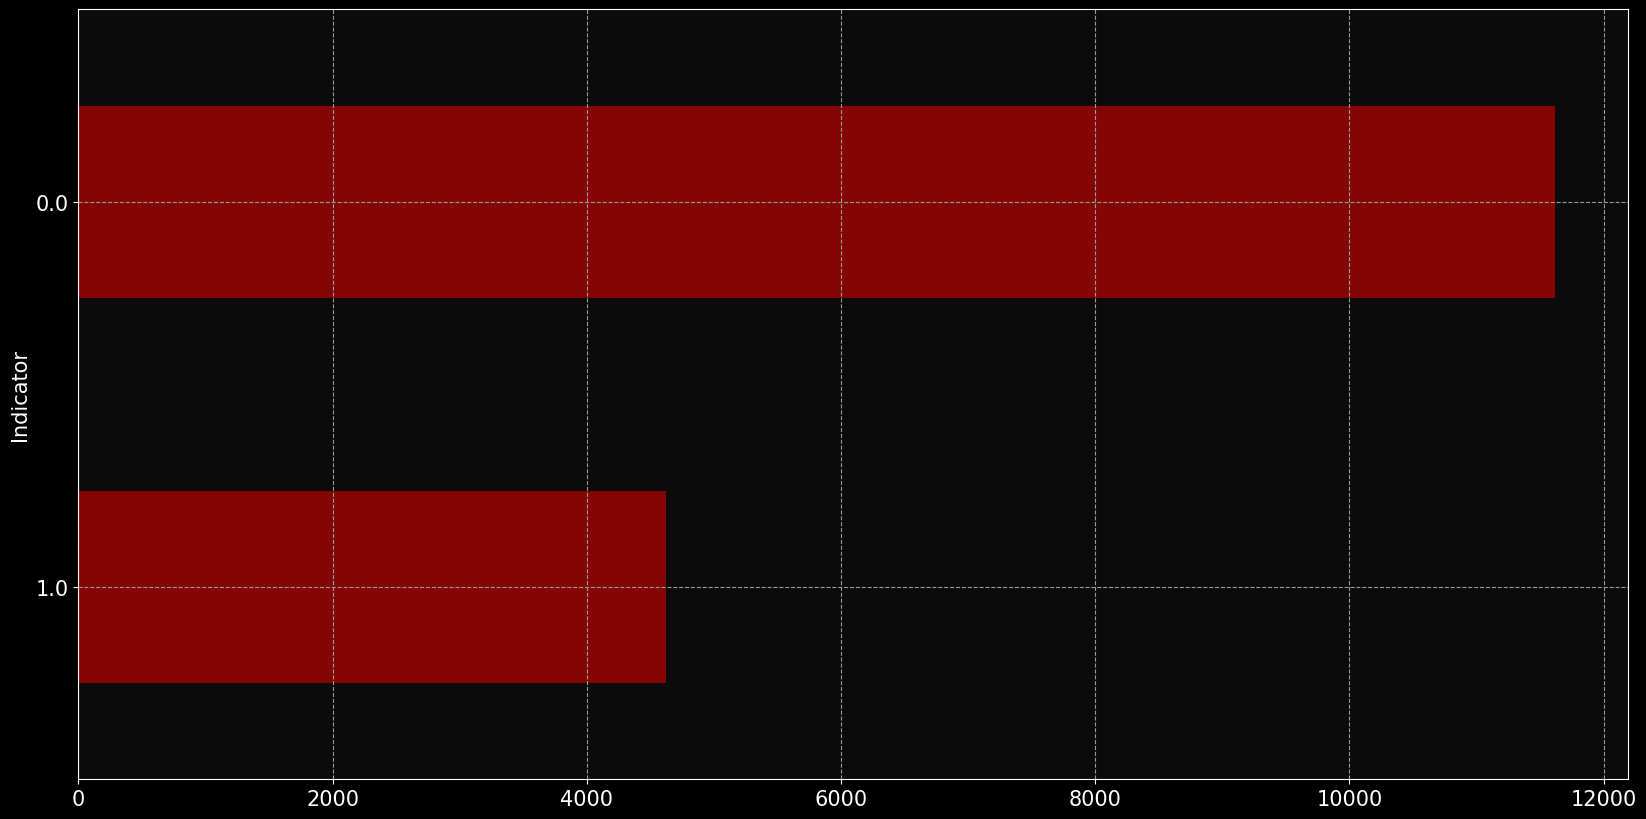

In [60]:
all_clean[['Indicator']].groupby('Indicator')['Indicator'].count().sort_values().plot(kind='barh',figsize=(20,10),color='red',alpha=0.5)

In [61]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 8.3MB/s 


In [62]:
(df_tweets[df_tweets['Ticker'] == 'RGBP'].groupby('Date')['Tweets'].count()[df_tweets[df_tweets['Ticker'] == 'RGBP'].groupby('Date')['Tweets'].count().apply(lambda x: x>=100)])

Date
2016-02-20     124
2016-09-16     168
2016-09-20     489
2016-09-21     184
2016-09-22     211
2016-09-29     173
2016-09-30     183
2017-03-02     176
2017-03-23     134
2019-05-08     105
2020-12-02     124
2020-12-03     120
2021-03-25     199
2021-04-08    2876
2021-04-09    2502
2021-04-10     947
Name: Tweets, dtype: int64

In [63]:
 from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
 analyzer = SentimentIntensityAnalyzer()

In [64]:
#len(columns_list_of_stocks[0:stocks_to_track])

In [91]:
Tweets = []
Ticker = []
Sentiment = []
Price = []
Dates = []
for Ticker_name in columns_list_of_stocks[0:600]:
  #print(Ticker_name)
  g = df_tweets[df_tweets['Ticker'] == Ticker_name].groupby('Date')
  #print((g.groups.keys()))
  idx = (df_tweets[df_tweets['Ticker'] == Ticker_name].groupby('Date')['Tweets'].count()[df_tweets[df_tweets['Ticker'] == Ticker_name].groupby('Date')['Tweets'].count().apply(lambda x: x>=100)].index)

  #print(g.groups.keys())#[pd.to_datetime(idx[0])])
  #print(g.groups[idx[0]])
  #groups = [unused_df for name,unused_df in g]

  for i,j in g:
    sentiment = []
    if i in idx:
      Dates.append(i)
      #print(i)
      for tweet in (j.iloc[:,2].values):
        #print(tweet)
        vs = analyzer.polarity_scores(tweet)
        Tweets.append(tweet)
        #sentiment.append(vs['compound'])
        if(vs['compound'])>=0.05:
          sentiment.append(1)
        elif (vs['compound'])>-0.05 and (vs['compound'])<0.05:
          sentiment.append(0)
        elif (vs['compound'])<=-0.05:
          sentiment.append(-1)
      counts = Counter(sentiment)
      #print(sentiment)
      #if counts.keys() in [0,1]
      #print(counts[-1],counts)
      net = (counts[1]-counts[-1])/(counts[1]+counts[0]+counts[-1])
      #print(net)
      Sentiment.append(net)
      Ticker.append(Ticker_name)
  #print("This is date",len(Dates))
  #print("This is sentiment",len(Sentiment))
  #ttt
      #ttt
  #Price.append(df_daily_average[[Ticker_name]].filter(items=Dates).values)
      
        
      


  
#print(Sentiment)      


In [92]:
Sentiment_df = pd.DataFrame({'Ticker_name':Ticker,'Sentiment_Score':Sentiment,'Dates':Dates})
#print(len(Dates))
#len(Tweets)
#len(Sentiment)
(Sentiment_df[Sentiment_df['Ticker_name']=='RGBP'])
#mp.plot(Sentiment_df['Date'],Sentiment_df['Sentiment_Score'],'o')
#print(len(Price),len(Ticker))
len(Sentiment_df.Ticker_name.unique())
Sentiment_df

,Ticker_name,Sentiment_Score,Dates
0,MBLV,0.220000,2021-01-25
1,MBLV,0.045455,2021-02-03
2,PRMO,0.104762,2021-02-08
3,PRMO,0.293706,2021-02-09
4,PRMO,0.197080,2021-02-10
...,...,...,...
16232,OPTI,0.416000,2021-04-05
16233,OPTI,0.401294,2021-04-06
16234,OPTI,0.371257,2021-04-07
16235,OPTI,0.321569,2021-04-08


In [93]:
Sentiment_df = Sentiment_df.rename(columns={'Dates':'Date'})

In [94]:
all_clean

,Tweet_counts,variable,Indicator,Date
1851,100.0,MBLV,1.0,2021-01-25
1860,132.0,MBLV,1.0,2021-02-03
1865,105.0,PRMO,1.0,2021-02-08
1866,143.0,PRMO,1.0,2021-02-09
1867,137.0,PRMO,1.0,2021-02-10
...,...,...,...,...
1921,375.0,OPTI,0.0,2021-04-05
1922,309.0,OPTI,0.0,2021-04-06
1923,334.0,OPTI,0.0,2021-04-07
1924,510.0,OPTI,0.0,2021-04-08


In [96]:

data=all_clean.merge(Sentiment_df,how='inner',left_on=['variable','Date'],right_on=['Ticker_name','Date'])
data=data.drop('variable',axis=1)

In [97]:
data[['Indicator']].groupby('Indicator')['Indicator'].count().sort_values()

Indicator
1.0     4622
0.0    11615
Name: Indicator, dtype: int64

In [98]:
df_daily_average.columns
copy = df_daily_average.reset_index().melt(id_vars='Date',value_vars=df_daily_average.reset_index().columns[1:]).rename(columns={'Symbols':'Ticker_name'}).rename(columns={'value':'Price'})
copy

,Date,Ticker_name,Price
0,2016-01-04,RGBP,0.156525
1,2016-01-05,RGBP,0.151250
2,2016-01-06,RGBP,0.146455
3,2016-01-07,RGBP,0.147500
4,2016-01-08,RGBP,0.148675
...,...,...,...
1205819,2021-04-07,PRHL,0.004100
1205820,2021-04-08,PRHL,0.005300
1205821,2021-04-09,PRHL,0.006400
1205822,2021-04-12,PRHL,0.004275


In [99]:
data.head(2)

,Tweet_counts,Indicator,Date,Ticker_name,Sentiment_Score
0,100.0,1.0,2021-01-25,MBLV,0.220000
1,132.0,1.0,2021-02-03,MBLV,0.045455


In [103]:
Final_data=copy.merge(data.reset_index(),how='left',left_on=['Date','Ticker_name'],right_on=['Date','Ticker_name']).drop('index',axis=1)#[~copy.merge(data.reset_index(),how='left',left_on=['Date','Ticker_name'],right_on=['Date','Ticker_name']).Tweet_counts.isnull()]
#Final_data = Final_data.set_index('Date')
Final_data = Final_data[~Final_data.Tweet_counts.isnull()]
Final_data

,Date,Ticker_name,Price,Tweet_counts,Indicator,Sentiment_Score
178,2016-09-16,RGBP,0.147512,168.0,0.0,0.357143
180,2016-09-20,RGBP,0.139328,489.0,0.0,0.654397
181,2016-09-21,RGBP,0.125200,184.0,0.0,0.293478
182,2016-09-22,RGBP,0.137250,211.0,0.0,0.189573
187,2016-09-29,RGBP,0.126885,173.0,0.0,0.236994
...,...,...,...,...,...,...
1204594,2016-05-24,PRHL,0.075850,294.0,0.0,0.336735
1204597,2016-05-27,PRHL,0.065125,363.0,0.0,0.198347
1204598,2016-05-31,PRHL,0.073250,396.0,0.0,0.348485
1204599,2016-06-01,PRHL,0.094697,678.0,1.0,0.646018


In [101]:
#Final_data = pd.merge(copy,data.reset_index(),on=['Ticker_name'])
#Final_data[Final_data.Ticker_name=='INND']

In [75]:
#Final_data.drop(['Date_x','Date_y'],axis=1)#[Final_data.Ticker_name == 'RGBP']
#Final_data[['Indicator']].groupby('Indicator')['Indicator'].count().sort_values().plot(kind='barh',figsize=(20,10),color='red',alpha=0.5)

In [76]:
#mp.figure(figsize=(20,10))
#mp.plot(df_daily_average.index,df_daily_average.RGBP)
#price_data = (Final_data[Final_data_2.Ticker_name=='RGBP'].Price-Final_data[Final_data_2.Ticker_name=='RGBP'].Price.min())/(Final_data[Final_data_2.Ticker_name=='RGBP'].Price.max()-Final_data[Final_data_2.Ticker_name=='RGBP'].Price.min())
#mp.plot(Final_data_2[Final_data.Ticker_name=='RGBP'].Date,price_data,'o')
#bar_data = (Final_data_2[Final_data_2.Ticker_name=='RGBP'].Tweet_counts-Final_data_2[Final_data_2.Ticker_name=='RGBP'].Tweet_counts.min())/(Final_data_2[Final_data_2.Ticker_name=='RGBP'].Tweet_counts.max()-Final_data_2[Final_data_2.Ticker_name=='RGBP'].Tweet_counts.min())
#mp.bar(Final_data_2[Final_data_2.Ticker_name=='RGBP'].Date,bar_data,width=40,color='blue')

In [77]:
#data.sort_values(by='Tweet_counts',ascending=False).Tweet_counts[0:100].plot(kind='bar',figsize=(20,10))
#mp.xticks(rotation=45)
#Final_data

In [104]:
Final_data=Final_data.merge(df_stocks['Volume'].reset_index().melt(id_vars='Date',value_vars=list(df_stocks['Volume'].columns)).rename(columns={'Symbols':'Ticker_name'}),how='inner',on=['Date','Ticker_name']).rename(columns={'value':'Volume'})

In [105]:
Final_data=Final_data[sorted(list(Final_data.columns))].set_index('Date')

In [106]:
Final_data.head(10).style.background_gradient(cmap=cm)

,Indicator,Price,Sentiment_Score,Ticker_name,Tweet_counts,Volume
Date,,,,,,
2016-09-16 00:00:00,0.000000,0.147512,0.357143,RGBP,168.000000,731072.000000
2016-09-20 00:00:00,0.000000,0.139328,0.654397,RGBP,489.000000,1570256.000000
2016-09-21 00:00:00,0.000000,0.125200,0.293478,RGBP,184.000000,491014.000000
2016-09-22 00:00:00,0.000000,0.137250,0.189573,RGBP,211.000000,1041242.000000
2016-09-29 00:00:00,0.000000,0.126885,0.236994,RGBP,173.000000,346951.000000
2016-09-30 00:00:00,0.000000,0.125988,0.295082,RGBP,183.000000,305557.000000
2017-03-02 00:00:00,1.000000,0.084000,-0.142045,RGBP,176.000000,2861525.000000
2017-03-23 00:00:00,0.000000,0.063225,0.052239,RGBP,134.000000,2273502.000000
2019-05-08 00:00:00,0.000000,0.001525,0.057143,RGBP,105.000000,134755187.000000


In [107]:
Final_data

,Indicator,Price,Sentiment_Score,Ticker_name,Tweet_counts,Volume
Date,,,,,,
2016-09-16,0.0,0.147512,0.357143,RGBP,168.0,731072.0
2016-09-20,0.0,0.139328,0.654397,RGBP,489.0,1570256.0
2016-09-21,0.0,0.125200,0.293478,RGBP,184.0,491014.0
2016-09-22,0.0,0.137250,0.189573,RGBP,211.0,1041242.0
2016-09-29,0.0,0.126885,0.236994,RGBP,173.0,346951.0
...,...,...,...,...,...,...
2016-05-24,0.0,0.075850,0.336735,PRHL,294.0,219863.0
2016-05-27,0.0,0.065125,0.198347,PRHL,363.0,109050.0
2016-05-31,0.0,0.073250,0.348485,PRHL,396.0,1390456.0


In [81]:
#Final_data.Volume = (Final_data.Volume-Final_data.Volume.min())/(Final_data.Volume.max()-Final_data.Volume.min())

In [82]:
#Final_data.Price =  (Final_data.Price-Final_data.Price.min())/(Final_data.Price.max()-Final_data.Price.min())

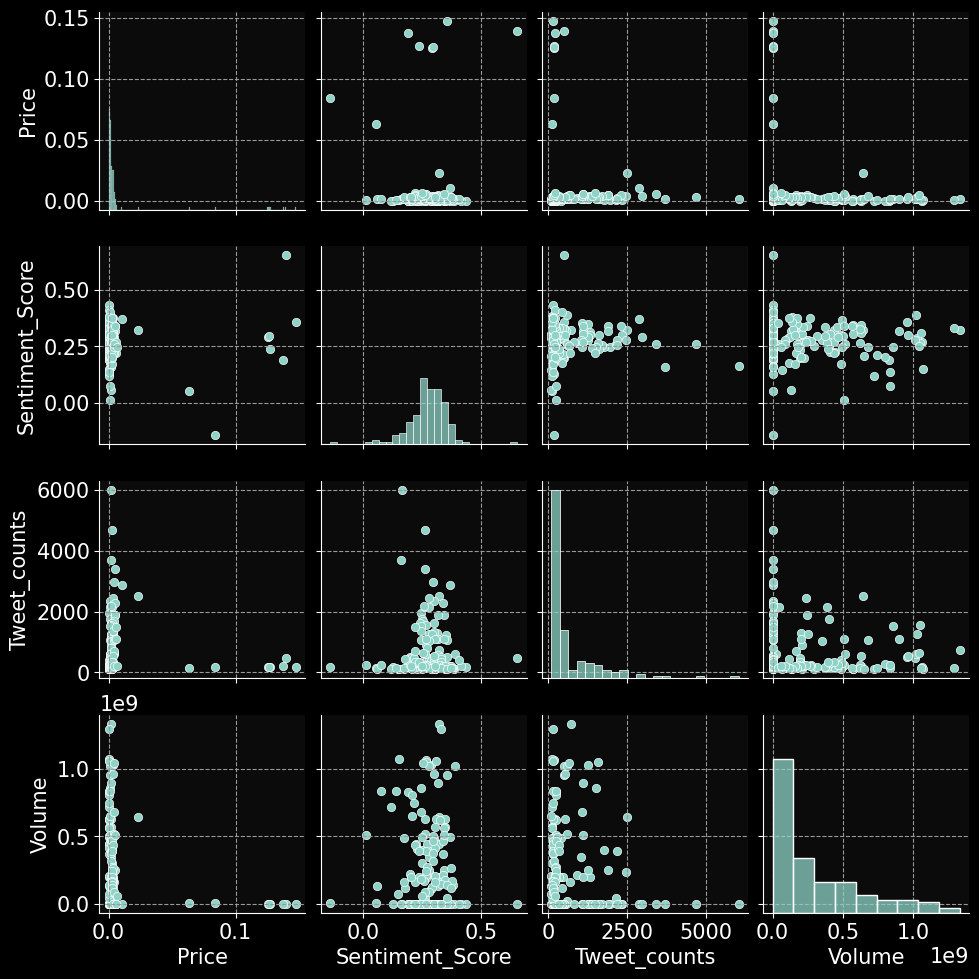

<Figure size 1000x1000 with 0 Axes>

In [108]:
import seaborn as sns
from IPython.display import Image
sns_plot = sns.pairplot(Final_data.iloc[0:150,:].drop('Indicator',axis=1))
sns_plot.savefig("pairplot.png")
mp.clf() # Clean parirplot figure from sns 
Image(filename='pairplot.png') # Show pairplot as image

Text(0.5, 0, 'Time')

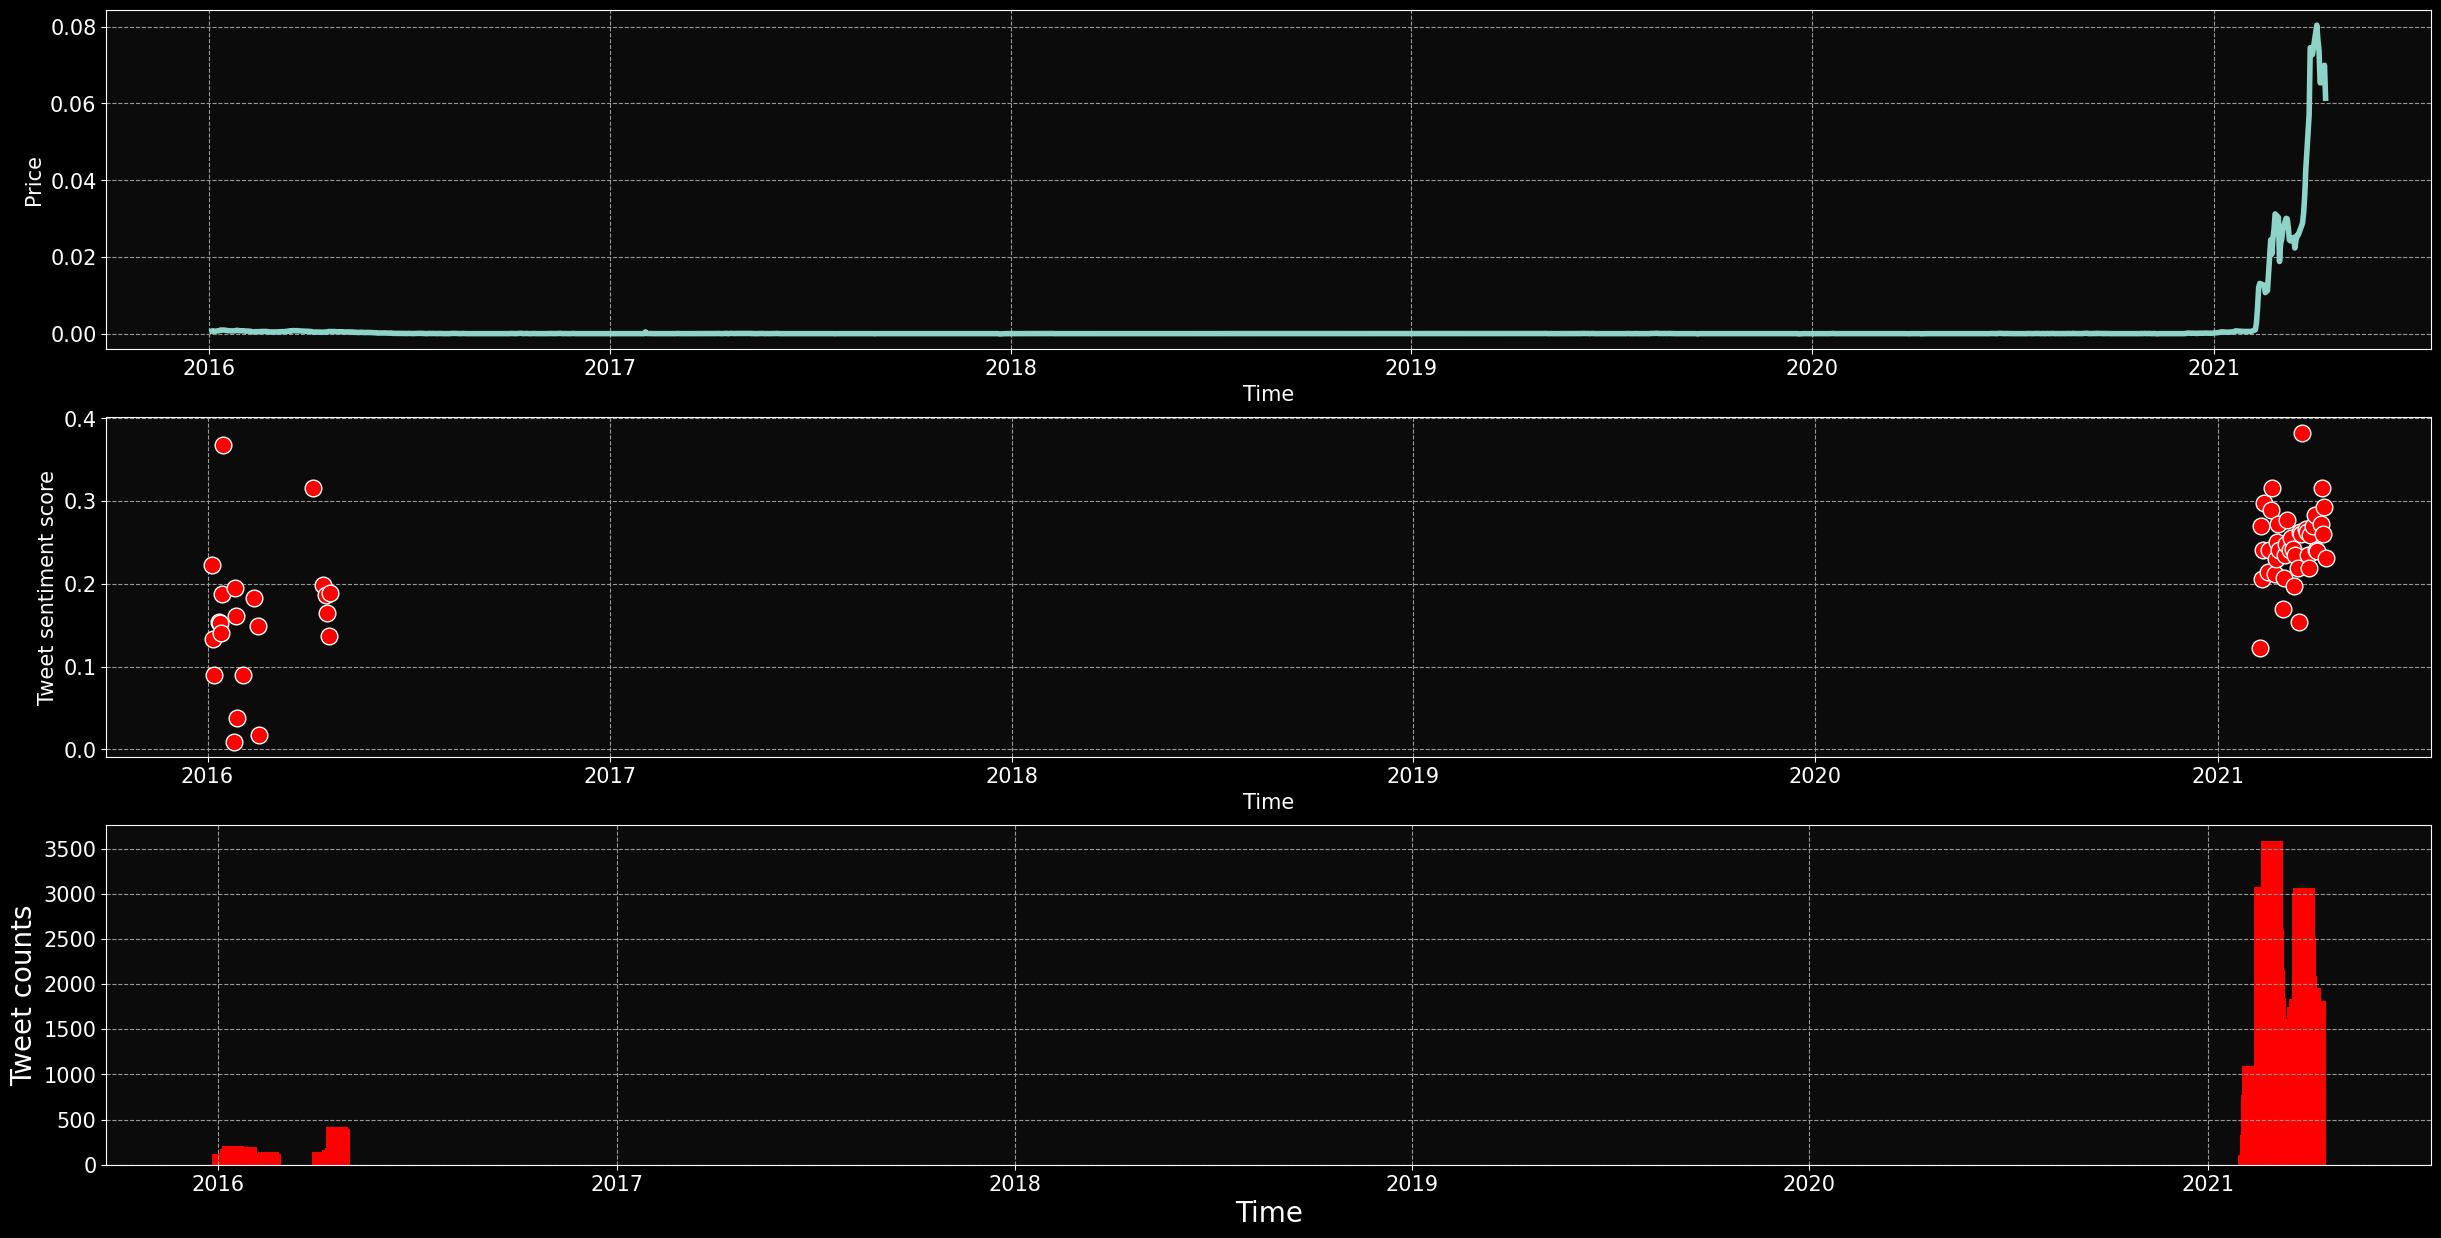

In [109]:
plot_LTNC = Final_data[Final_data.Ticker_name=='LTNC'].Sentiment_Score
bar_LTNC = Final_data[Final_data.Ticker_name=='LTNC'].Tweet_counts
fig,ax = mp.subplots(3,1,figsize=(30,15))
ax[1].plot(plot_LTNC.index, plot_LTNC.values,'o',color='red',markersize=12,markeredgecolor='white')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Tweet sentiment score')
ax[0].plot(df_daily_average.index, df_daily_average.LTNC,linewidth=4)
ax[0].set_ylabel('Price')
ax[0].set_xlabel('Time')
ax[2].bar(bar_LTNC.index,bar_LTNC.values,width=20,color='red')
ax[2].set_ylabel('Tweet counts',fontsize=20)
ax[2].set_xlabel('Time',fontsize=20)

In [111]:
Final_data.to_csv('/content/drive/MyDrive/OTCMKT/Final_data.csv',index=True)